In [3]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd

import sys
sys.path.append("../")
from nnperm.spec import PermutationSpec

In [4]:
def fp_rows(fixed_points_dict, other_values, layers):
    rows = []
    all_nonzero, all_total = 0, 0
    for i, k in enumerate(layers):
        nonzero = np.count_nonzero(fixed_points_dict[k])
        total = len(fixed_points_dict[k])
        rows.append({
            "layer": k,
            "layer.number": i,
            "fixed_points": nonzero,
            "total": total,
            "fraction": nonzero / total,
            **other_values
        })
        all_nonzero += nonzero
        all_total += total
    rows.append({
        "layer": "all",
        "fixed_points": all_nonzero,
        "total": all_total,
        "fraction": all_nonzero / all_total,
        **other_values
    })
    return rows

def barrier_rows(barriers_dict):
    return {
        **{k: max(v) if "loss" in k else -min(v) if "acc" in k else len(v) for k, v in barriers_dict.items()},
        **{k+".idx": np.argmax(v) if "loss" in k else np.argmin(v) if "acc" in k else len(v) for k, v in barriers_dict.items()},
    }

def make_df(model):
    file = f"../refactor-outputs/transitivity/{model}-ep150.pt"
    stats = torch.load(file)
    ps_file = next(iter(Path(f"../refactor-outputs/layer-align-more-bias/{model}/replicate_1-2").glob("perm-*.pt")))
    _, perm_spec = PermutationSpec.load_from_file(ps_file)
    layers = list(perm_spec.group_to_axes.keys())

    barrier_df = []
    fixed_points_df = []
    for item in stats["stats"]:
        path_info = {
            "path": item['path'],
            "path_len": len(item['path']),
        }
        barrier_df.append({**path_info, "cycle": False, "train": True, **barrier_rows(item["path_train"])})
        barrier_df.append({**path_info, "cycle": False, "train": False, **barrier_rows(item["path_test"])})
        barrier_df.append({**path_info, "cycle": True, "train": True, **barrier_rows(item["cycle_train"])})
        barrier_df.append({**path_info, "cycle": True, "train": False, **barrier_rows(item["cycle_test"])})
        fixed_points_df += fp_rows(item["path_fixed_points"], {**path_info, "cycle": False}, layers)
        fixed_points_df += fp_rows(item["cycle_fixed_points"], {**path_info, "cycle": True}, layers)
    barrier_df = pd.DataFrame(barrier_df)
    fixed_points_df = pd.DataFrame(fixed_points_df)
    return barrier_df, fixed_points_df

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_barrier(data, title): 
    ticks = [int(x) for x in data["path_len"].unique()]
    ax = sns.lineplot(data=data, x="path_len", y="acc_barrier")
    ax.set(xticks=ticks, xticklabels=[x - 1 for x in ticks])
    ax.set_ylim(0., 1.)
    ax.set_title(title)
    ax.set_xlabel("Permutations")
    ax.set_ylabel("Error barrier")
    plt.show()

def plot_train_test(data, title):
    plot_barrier(data[data["train"]], title + " train")
    plot_barrier(data[~data["train"]], title + " test")

def plot(name, barrier_df, fixed_points_df):
    plot_train_test(barrier_df[~barrier_df["cycle"]], name)
    plot_train_test(barrier_df[barrier_df["cycle"]], name + " cycle")
    ax = sns.lineplot(data=fixed_points_df[fixed_points_df["cycle"]], x="path_len", y="fraction", hue="layer.number")
    ax.set(xticks=[2, 3, 4], xticklabels=[1, 2, 3])
    ax.set_title(f"{name} fixed points")
    ticks = [int(x) for x in fixed_points_df["path_len"].unique()]
    ax.set(xticks=ticks, xticklabels=[x - 1 for x in ticks])
    ax.set_xlabel("Permutations")
    ax.set_ylabel("Error barrier")
    plt.show()

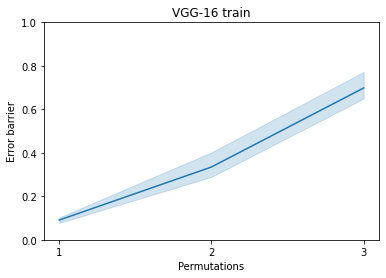

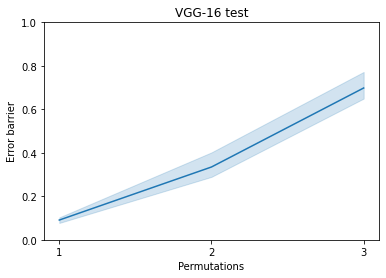

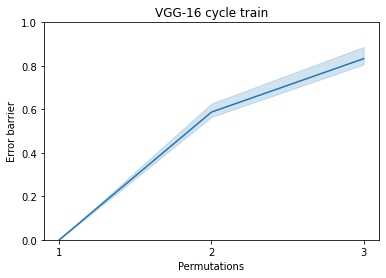

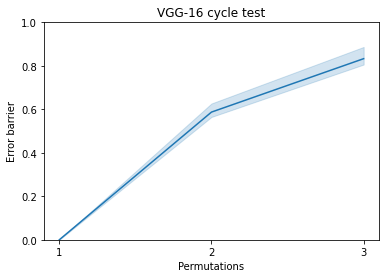

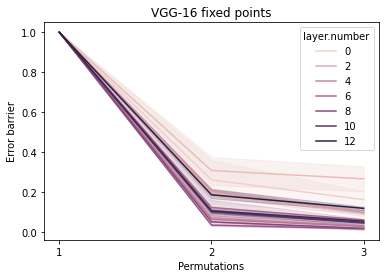

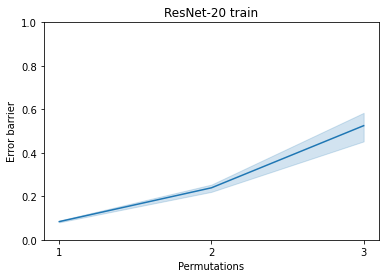

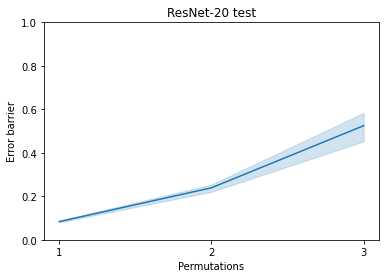

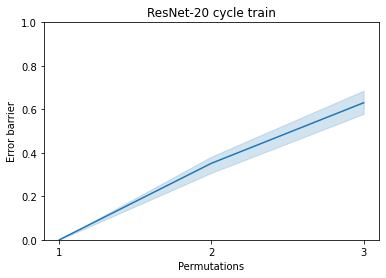

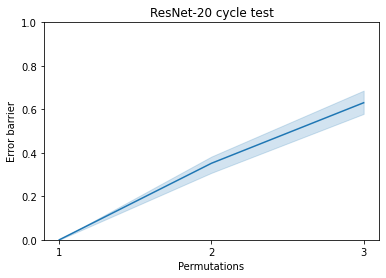

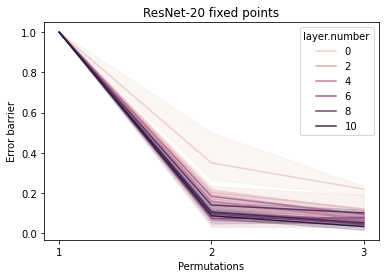

In [6]:
models = {"VGG-16": "lottery_8146fc7e9839615729ee764a8019bdc5",
          "ResNet-20": "lottery_0683974d98b4b6cb906aa0b80db9e2f5"
          }

for k, v in models.items():
    plot(k, *make_df(v))